In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [5]:
import torch.optim as optim

In [6]:
image_path = '/Users/karthik/GANS/Rezied_GRADIENT_k7/Pattern_FeatureIdx_1003_TopoUnit_4X4.png'


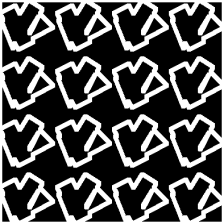

In [7]:
with Image.open(image_path) as img:
    display(img)

In [8]:
path = '/Users/karthik/GANS/Rezied_GRADIENT_k7/'

img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+ '/' +img)
        
print('Images: ',len(img_names))

Images:  2176


In [9]:
img_sizes = []

rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
            
    except:
        rejected.append(item) 

In [10]:
print(len(img_sizes))

2176


In [11]:
df = pd.DataFrame(img_sizes)

In [12]:
df.head()

,0,1
0,224,224
1,224,224
2,224,224
3,224,224
4,224,224


In [13]:
df.describe()

,0,1
count,2176.0,2176.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


**Parameters**

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 112
image_dim = 224 * 224 * 1  # 50176, for grayscale images
batch_size = 32
num_epochs = 200

In [15]:
transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [17]:
torch.manual_seed(42)

root = '/Users/karthik/GANS/Rezied_GRADIENT_k7/'
print(os.path.exists(root))

True


In [18]:
import shutil

class_dir = os.path.join(root, 'gradient_bio_materials')
os.makedirs(class_dir, exist_ok=True)

for entry in os.scandir(root):
    if entry.is_file() and entry.name.endswith('.png'):  
        shutil.move(entry.path, class_dir)


train_data = datasets.ImageFolder(root, transform=transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [19]:
for images, labels in train_loader:
    break

In [20]:
images.shape

torch.Size([32, 1, 224, 224])

**Constructing the Discriminator**

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

**Contrusting the Generator**

In [22]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(), 
        )

    def forward(self, x):
        return self.gen(x)

In [23]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [24]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

In [25]:
from torch.utils.tensorboard import SummaryWriter 

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0
fixed_noise = torch.randn(16, z_dim).to(device)   # 32 -> 16

In [26]:
images_processed = 0

In [27]:
print(len(train_loader))

68


In [28]:
for epoch in range(num_epochs): 
    for batch_idx, (real, _) in enumerate(train_loader):
        
        real = real.view(-1, 50176).to(device)  # Flatten the images into vectors
        batch_size = real.shape[0]

        # Generate random noise as input for the generator
        noise = torch.randn(batch_size, z_dim).to(device)
        
        # Generate fake images with the generator
        fake = gen(noise)
        
        # Compute the discriminator losses on real images
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        # Compute the discriminator losses on fake images
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        # Combine losses for the discriminator
        lossD = (lossD_real + lossD_fake) / 2
        
        # Update discriminator
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # Update generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()



    # After all batches are processed for the current epoch, check if it's time to print
    if (epoch + 1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1,1,224,224)
            data = real.reshape(-1, 1, 224, 224)
            
            img_grid_real = torchvision.utils.make_grid(data[:16], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)

            writer_real.add_image("Real", img_grid_real, global_step=step)
            writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        # The print statement has been moved outside of the inner loop, and the condition is changed to every 5 epochs
        print(f"Epoch [{epoch}/{num_epochs}] Completed - Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

    # Increment the step after each epoch
    step += 1



Epoch [0/200] Completed - Loss D: 0.0293, loss G: 5.2858
Epoch [4/200] Completed - Loss D: 0.0007, loss G: 7.6177
Epoch [9/200] Completed - Loss D: 0.0458, loss G: 2.6017
Epoch [14/200] Completed - Loss D: 0.2802, loss G: 0.9120
Epoch [19/200] Completed - Loss D: 0.3091, loss G: 0.8256
Epoch [24/200] Completed - Loss D: 0.2666, loss G: 0.9692
Epoch [29/200] Completed - Loss D: 0.3091, loss G: 1.2117
Epoch [34/200] Completed - Loss D: 0.2390, loss G: 1.9647
Epoch [39/200] Completed - Loss D: 0.1757, loss G: 1.0511
Epoch [44/200] Completed - Loss D: 0.0643, loss G: 2.5173
Epoch [49/200] Completed - Loss D: 0.5058, loss G: 0.7837
Epoch [54/200] Completed - Loss D: 0.1491, loss G: 1.9620
Epoch [59/200] Completed - Loss D: 0.1906, loss G: 2.0475
Epoch [64/200] Completed - Loss D: 0.3020, loss G: 2.5446
Epoch [69/200] Completed - Loss D: 0.3328, loss G: 2.8246
Epoch [74/200] Completed - Loss D: 0.3922, loss G: 2.2502
Epoch [79/200] Completed - Loss D: 0.1577, loss G: 2.0363
Epoch [84/200] Co